In [23]:
# Imports

%matplotlib inline
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import *
import math
import random
from scipy.stats import pearsonr
import sys
from joblib import Parallel, delayed
import multiprocessing
nproc = max(1, multiprocessing.cpu_count() - 1)
from functools import partial

from sklearn import linear_model
from sklearn import ensemble
from scipy.spatial import distance
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.grid_search import GridSearchCV

if 'utils' not in sys.path:
    sys.path.append('utils')

import data_loader

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent, cached data retrieval script

print(data_loader.load_chromosome.__doc__)
train_df, test_df, train_ix, test_ix, train_tissues, tfs = \
    data_loader.load_chromosome_cached('1')

Idempotent data loading. For a given chromosome n (a string).
    
    Returns (train_df, test_df, train_ix, test_ix, train_tissues, tfs)
    
    The first two are the train and test dataframes, and test_ix are the
    values in test_df['assayed'] that are missing and need to be imputed (with the
    correct answer being in test_df['filled'] in the corresponding locations.
    train_ix are the assayed (known) methylation values from limited microarray
    sampling (e.g., test_df['assayed'].iloc[train_ix] can be used for prediction of
    test_df['filled'].iloc[test_ix], and the former should be about equal to
    test_df['filled'].iloc[train_ix] (two different ways of sampling methylation).
    
    Imports genetic context and adds those columns to the parameter df, returning
    a merged one. tfs is the list of names of new transcription
    factors.
    
    train_tissues is a list of the names of columns with chromosome methylation values.
    
    Note that loading from scratch ma

In [24]:
# Double check that there actually are transcription factors in there:
train_df[list(tfs)].sum().sum()

413436

In [25]:
print('Num train tissues', len(train_tissues))
print('Num trans factors', len(tfs))

display_cols = list(train_df.columns)[:]
for i in train_tissues[2:] + tfs[2:]:
    display_cols.remove(i)
print('Dropping all but first two tissues, transcription factors.')
train_df.loc[range(267, 273)][display_cols]

Num train tissues 34
Num trans factors 161
Dropping all but first two tissues, transcription factors.


,chromosome,start,end,strand,b0,b1,GABPA,ZBTB33
267,chr1,121511,121513,True,0.714286,0.739130,False,False
268,chr1,121516,121518,True,0.857143,0.800000,False,False
269,chr1,122736,122738,False,0.545455,0.384615,False,False
270,chr1,122869,122871,False,0.837838,0.814815,False,False
271,chr1,122884,122886,False,0.842105,0.821429,False,False
272,chr1,127749,127751,True,0.633333,0.473684,False,False


In [26]:
assert len(train_df) == len(test_df)
def count_unique(col):
    return {x:sum(col == x) for x in set(col)}

print('Chromosome 1')
print('Total samples', len(train_df))
print('Site lengths', count_unique(train_df['end'] - train_df['start']))
print('Strand types', count_unique(train_df['strand']))
print('Known (test) sample site counts', len(train_ix))
print('Unknown (test) sample site counts', len(test_ix))
print('NaN ratio in all train samples',
      sum(sum(np.isnan(train_df[train_tissues].values))) / (len(train_df) * len(train_tissues)))
print('NaN ratio in test', sum(np.isnan(test_df['missing'])) / len(test_df))
assert sum(test_df['strand'] != train_df['strand']) == 0

Chromosome 1
Total samples 379551
Site lengths {2: 379551}
Strand types {False: 1464, True: 378087}
Known (test) sample site counts 7523
Unknown (test) sample site counts 368411
NaN ratio in all train samples 0.0849950103582
NaN ratio in test 0.980179211753


In [27]:
for t in train_tissues:
    print(t, 'sparsity', (train_df[t] == 0).sum() / len(train_df))

b0 sparsity 0.0
b1 sparsity 0.0
b2 sparsity 0.0
b3 sparsity 0.0
b4 sparsity 0.0
b5 sparsity 0.0
b6 sparsity 0.0
b7 sparsity 0.0
b8 sparsity 0.0
b9 sparsity 0.0
b10 sparsity 0.0
b11 sparsity 0.0
b12 sparsity 0.0
b13 sparsity 0.0
b14 sparsity 0.0
b15 sparsity 0.0
b16 sparsity 0.0
b17 sparsity 0.0
b18 sparsity 0.0
b19 sparsity 0.0
b20 sparsity 0.0
b21 sparsity 0.0
b22 sparsity 0.0
b23 sparsity 0.0
b24 sparsity 0.0
b25 sparsity 0.0
b26 sparsity 0.0
b27 sparsity 0.0
b28 sparsity 0.0
b29 sparsity 0.0
b30 sparsity 0.0
b31 sparsity 0.0
b32 sparsity 0.0
b33 sparsity 0.979949993545


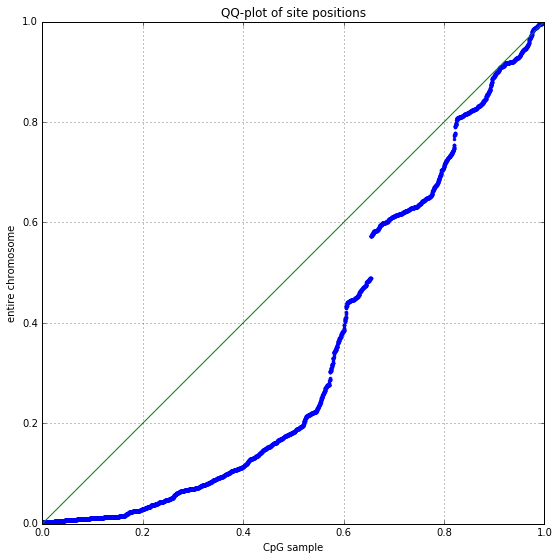

avg length between known sites 33058.4680936
sd of number of bp between sites 262002.205837


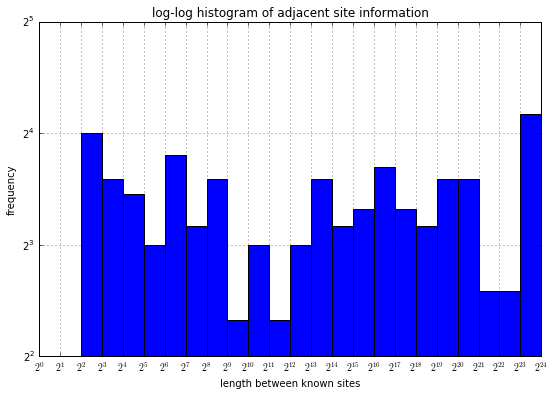

In [29]:
# Make sure our samples are pretty uniform from the genomic range

sites = test_df['start'][train_ix].values

def ticks(n): return np.arange(0.0, n) / n

plt.figure(figsize=(9,9))
plt.ylim([0, 1])
plt.plot(ticks(len(sites)), sites / (sites.max() - sites.min()), '.')
plt.plot([0, 1])
plt.axes().set_aspect('equal')
plt.xlabel('CpG sample')
plt.ylabel('entire chromosome')
plt.title('QQ-plot of site positions')
plt.grid(True)
plt.show()

diffs = np.diff(sites)
print('avg length between known sites', np.mean(diffs))
print('sd of number of bp between sites', np.std(diffs))

def maxlgbin(series): return math.ceil(np.log2(series.max()))

bins = range(maxlgbin(diffs))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
plt.hist(diffs, bins=bins)
plt.gca().set_yscale('log', basey=2)
plt.xlabel('length between known sites')
plt.ylabel('frequency')
plt.title('log-log histogram of adjacent site information')
plt.grid(True)
plt.show()

In [30]:
# Observe nearby site correlations

def correlation(x, y):
    ix = np.where(~np.isnan(x) & ~np.isnan(y))
    return pearsonr(x[ix], y[ix])[0]

# rm b33
X = train_df[train_tissues[:-1]].values

# Choose a random site, check neighbors within vicinity of 'reach'
reach = list(range(30))
reach = [-x for x in reversed(reach)] + reach[1:]

sample = 50000
sites = np.random.randint(max(reach), len(train_df) - max(reach) - 1, sample)
nbrs = [i + sites for i in reach]

site_vals = X[sites]
nbrs_vals = [X[nbr] for nbr in nbrs]
corrs = np.array([[correlation(x, y) for x, y in zip(site_vals, nbr_vals)] for nbr_vals in nbrs_vals])

plt.errorbar(reach, np.mean(corrs, axis=1), fmt='-o', yerr=np.std(corrs, axis=1))
plt.title('within tissue neighbor correlation (n={}K)'.format(sample // 1000))
plt.ylabel('across tissue samples')
plt.xlabel('site displacement')
plt.show()

KeyboardInterrupt: 

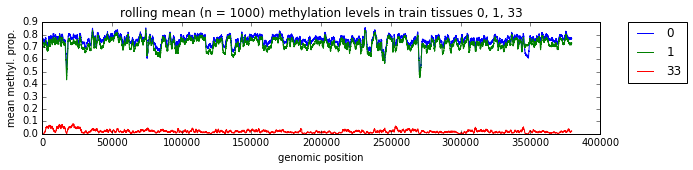

orig : rolling mean stddevs [4.8264430391409112, 4.6245001454552384, 11.339790875795508]


In [31]:
# Perhaps there are obvious sequence trends?
def local_impute(data):
    #http://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

plt.figure(figsize=(10, 2))
ratios = []
plt.title('rolling mean (n = 1000) methylation levels in train tissues 0, 1, 33')
plt.xlabel('genomic position')
plt.ylabel('mean methyl. prop.')

x = local_impute(np.copy(train_df['b0']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l0, = plt.plot(rolled, label='0')

x = local_impute(np.copy(train_df['b1']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l1, = plt.plot(rolled, label='1')

x = local_impute(np.copy(train_df['b33']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l33, = plt.plot(rolled, label='33')

plt.legend(handles=[l0, l1, l33])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print('orig : rolling mean stddevs', ratios)

In [32]:
# Sparsity
print('Training tissue sparsities', [(train_df[i] <= 0.01).sum() / len(train_df) for i in train_tissues])
print('Sample sparsity', (test_df['filled'][train_ix] <= 0.01).sum() / len(train_ix))

Training tissue sparsities [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.97994999354500445]
Sample sparsity 0.0


In [33]:
# Do mean imputation on our training data.
def mean_impute(data):
    mask = np.isnan(data)
    data[mask] = float(data.mean()) # just = m messes with serialization
    return data
train_df_imp = train_df
train_df_int = train_df
for i in train_tissues:
    train_df_imp[i] = mean_impute(train_df[i].copy())
    train_df_int[i] = local_impute(train_df[i].copy())
print('nans in mean-imputed', np.isnan(train_df_imp[train_tissues]).sum().sum())
print('nans in interpolated', np.isnan(train_df_int[train_tissues]).sum().sum())

nans in mean-imputed 0
nans in interpolated 0


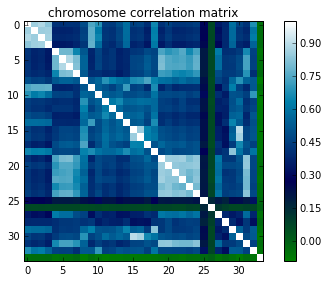

closest to test sample based on training data: 19


In [34]:
corr_mat = [[pearsonr(train_df_imp[a], train_df_imp[b])[0]
             for a in train_tissues] for b in train_tissues]
plt.imshow(corr_mat, interpolation='nearest', cmap=plt.cm.ocean)
plt.title('chromosome correlation matrix')
plt.colorbar()
plt.tight_layout()
plt.show()

def pandas_rmse(a, b):
    # http://stackoverflow.com/questions/27783494/root-mean-square-error-of-two-pandas-series
    return math.sqrt(a.sub(b).pow(2).mean())

l = [pandas_rmse(train_df_imp[t].iloc[train_ix], test_df['filled'][train_ix]) for t in train_tissues]
print('closest to test sample based on training data:', l.index(min(l)))

In [45]:
for i in range(34):
    if i not in perm:
        print(i)
print(len(perm))

34


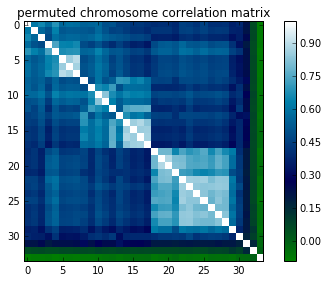

In [49]:
# permuted correlation matrix
perm = [11, 12, 13, 17, 8, 15, 16, 30, 10, 14, 18, 29, 9, 32, 0, 1, 2, 3, 4, 5, 6, 7, 19, 20, 21, 22, 23, 24, 31, 27, 28, 25, 26, 33]
permuted_tt = np.array(train_tissues)[perm]

corr_mat = [[pearsonr(train_df_imp[a], train_df_imp[b])[0]
             for a in permuted_tt] for b in permuted_tt]
plt.imshow(corr_mat, interpolation='nearest', cmap=plt.cm.ocean)
plt.title('permuted chromosome correlation matrix')
plt.colorbar()
plt.tight_layout()
plt.show()

33 33 33


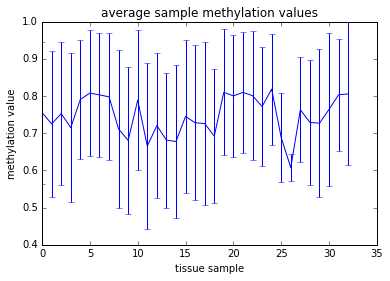

In [26]:
means = train_df_int[train_tissues[:-1]].mean(axis=0)
stds = train_df_int[train_tissues[:-1]].std(axis=0)
print(len(means), len(stds), len(train_tissues[:-1]))
plt.errorbar(range(len(train_tissues[:-1])), means, fmt='-', yerr=stds)
plt.title('average sample methylation values')
plt.ylabel('methylation value')
plt.xlabel('tissue sample')
plt.show()

In [ ]:
#TODO(vlad17): testing code should be in a diff notebook. (pull out useful code to Jerry and Sid's nb)

In [46]:
# Define some evaluation functions. Filter out the bad chromosomes

for i in [14, 25, 26, 33]:
    s = 'b' + str(i)
    if s in train_tissues: train_tissues.remove(s)
testable_tissues = train_tissues[:]


def denanify(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    assert mask.sum() > 0
    return a[mask], b[mask]

def correct_half(a, b):
    methylated_guess = a >= 0.5
    methylated_exact = b >= 0.5
    return (methylated_guess == methylated_exact).sum() / len(methylated_guess)

# Function f should return its estimate for the value in 'test_tissue'
# at each test_ix location. It gets its own copy of test_tissue, but
# train_cols is shared.
def eval_fold(f, train_cols, test_tissue, train_tissue_names):
    nanned = test_tissue.copy()
    nanned[test_ix] = np.nan
    guess = f(train_cols, nanned, train_tissue_names)
    assert sum(np.isnan(guess)) == 0
    # test_ix doesn't have nans in the test_df['filled'] col, but
    # within train_df there might be nans here.
    exact = test_tissue[test_ix]
    if not isinstance(guess, pd.Series):
        guess = pd.Series(guess, index=exact.index)
    assert len(guess) == len(exact)
    guess, exact = denanify(guess, exact)
    return np.array([pandas_rmse(guess, exact), correct_half(guess, exact),
                     r2_score(exact, guess)])

df = train_df_int

# Excludes the sparse chromosome from testing.
def cv_folds(f, df=df, threading='multiprocessing',
             additional_cols=[], test_tissues=testable_tissues):
    rmse_acc = np.zeros(3)
    ctr = 0
    arguments = []
    for t in test_tissues:
        train_cols = train_tissues[:]
        train_cols.remove(t)
        arguments.append((f, df[train_cols + additional_cols], df[t], train_cols))
    folds = [eval_fold(*i) for i in arguments] if not threading else \
            Parallel(n_jobs=min(nproc, len(arguments)), backend=threading) \
                (delayed(eval_fold)(*i) for i in arguments)
    folds = np.array([i[2] for i in folds])
    return np.median(folds)

def perfstr(rmse_acc):
    return 'R^2 {}'.format(rmse_acc)

In [47]:
# No trends.
# Let's try imputing from but clearly we can impute from local neighbor data.
# Try using no information for our test chromosome as a baseline.

# Two simple approaches, with no information from other samples

def interpolation(cols, partial, train_tissue_names):
    return local_impute(partial).iloc[test_ix]
print('interpolation', perfstr(cv_folds(interpolation)))

def same_sample_mean(cols, partial, train_tissue_names):
    return mean_impute(partial).iloc[test_ix]
print('same tissue mean', perfstr(cv_folds(same_sample_mean)))

interpolation R^2 -0.5935641415132022
same tissue mean R^2 -0.03142105397944095


In [48]:
# As a dual approach, we can try using only information from the remaining tissues
# For example, we might try to take a mean of methylation values along the same site
def diff_sample_mean(cols, partial, train_tissue_names):
    return cols[train_tissue_names].iloc[test_ix].mean(axis=1)
print('diff tissue mean', perfstr(cv_folds(diff_sample_mean)))

diff tissue mean R^2 0.44897468897753867


In [49]:
def nearest_neighbor(cols, partial, train_tissue_names):
    nbr = min((pandas_rmse(cols[t].iloc[train_ix], partial.iloc[train_ix]), t)
              for t in train_tissue_names)[1]
    return cols[nbr].iloc[test_ix]
print('1NN', perfstr(cv_folds(nearest_neighbor, df=train_df_imp)))

1NN R^2 0.6500196424864586


In [76]:
# Use the well-formedness of the other-tissue data to train a basic lm
def sklearn_model(lm, cols, partial, train_tissue_names):
    lm.fit(cols.iloc[train_ix], partial.iloc[train_ix])
    return lm.predict(cols.iloc[test_ix])

def log_range(lo, hi): return [10 ** i for i in range(lo, hi)]
alphas = log_range(-5, 4)
lm = linear_model.LassoCV(alphas=alphas, cv=8)

print('ElasticNet', perfstr(cv_folds(partial(sklearn_model, lm), df=df)))
print('only tissue data')

ElasticNet R^2 0.7813277165350101
only tissue data


In [77]:
best_combined = linear_model.Lasso()
grid = GridSearchCV(best_combined, {'alpha': alphas}, cv=30, n_jobs=nproc)
grid.fit(df[train_tissues].iloc[train_ix], test_df['filled'].iloc[train_ix])
grid.best_params_

{'alpha': 1e-05}

In [78]:
def evaluate_method(guess, name):
    exact = test_df['filled'].iloc[test_ix].values
    rmse = math.sqrt(mean_squared_error(exact, guess))
    r2 = r2_score(exact, guess)
    res = guess - exact

    print('{}: rmse {:04f} R^2 {:04f}'.format(name, rmse, r2))

guess = grid.predict(df[train_tissues].iloc[test_ix])
evaluate_method(guess, 'Lasso')
evaluate_method(nearest_neighbor(df, test_df['filled'], train_tissues), 'NN')

Lasso: rmse 0.060040 R^2 0.873934
NN: rmse 0.067787 R^2 0.839305
